<a href="https://colab.research.google.com/github/olakoja/Models_for_non-places/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D0%91%D0%B5%D0%B7_%D1%80%D0%B0%D1%81%D1%87%D1%91%D1%82%D0%B0_%D0%B4%D0%BE%D1%81%D1%82%D0%BE%D0%B2%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BA%D0%B0%D0%B6%D0%B4%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Необходимые бибилиотеки

In [24]:
import warnings
from pandas.errors import PerformanceWarning
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

# Вводные

In [25]:
# Загрузка данных
polygons = gpd.read_file("/content/1POLYGONS.gpkg") #Путь к файлу и его название файла поменять на своё

# Удаление ненужных столбцов. От размера этих списков скорость работы алгоритма будет зависеть не сильно
excess_column = ['name', 'layer', 'other_tags', 'path', 'type', 'neighbor_boundary_length_None',
                 'neighbor_ratio_None', 'building:levels', 'point_count', 'ref', 'height', 'leaf_type',
                 'description', 'start_date', 'url', 'Санкт-Петербург)', 'area', 'boundary_length',
                 'operator', 'brand' , 'ball', 'phone', 'email', 'source:height'
                 ]  # Точные названия столбцов, которые нужно удалить
values = [
    'name:', 'wikipedia', 'wikidata', 'website', 'neighbor_boundary_length', 'level', 'addr',
    'building:', 'opening_hours', 'roof:', 'name', 'design:', 'contact:', 'note_', 'official_status',
    'image', '_id', 'kpoos_', 'oktmo:', ':00', '_2', '_3', '_4', 'shop_within', 'osm_', 'comment', 'brand:'
] # Перечень слов, которые не должны попадаться в столбцах на обработку


# Подготовка данных

In [26]:
# Отключаем предупреждения (Просто, чтобы уменьшить количество строк в выоде)
warnings.filterwarnings("ignore", category=PerformanceWarning)

polygons = polygons.drop(columns=excess_column, errors='ignore')
# Обработка целевой переменной
polygons['non-place1'] = polygons['non-place1'].replace({...})  # Ваши замены
non_place1_column = polygons['non-place1']
polygon = polygons.drop(columns=['non-place1'])

# Подготовка данных
# 3.4 Удаляем ненужные столбцы
polygons = polygons.iloc[:,:]
try:
  polygons = polygons.drop(columns=excess_column, errors='ignore')
except Exception:
  pass

polygons = polygons.drop(columns=polygons.columns[polygons.columns.str.contains('|'.join(values))])

# polygons = polygons.loc[:, ~polygons.columns.str.contains('shop_within|name:|contact:website')]
# Сохранение целевой переменной

polygons['non-place1'] = polygons['non-place1'].replace({'I': 'other', 'II': 'other', 'III': 'other', 'pustoe': 'other', 'water': 'other'})

non_place1_column = polygons['non-place1']

# Удаление исходного столбца 'non-place1' перед обработкой
polygon = polygons.drop(columns=['non-place1'])

# Удаляем столбцы, где слишком мало значений
# threshold = 0.04 * len(polygon)
# Удаляем столбцы, где количество ненулевых значений меньше 4%
# polygon = polygon.loc[:, polygon.notnull().sum() > threshold]


if 'area' in polygon.columns:  # Проверяем, есть ли столбец 'area'
    if polygon['area'].dtype == 'object':  # Проверяем, является ли столбец текстовым
        polygon['area'] = polygon['area'].astype(float)
else:
    print("Столбец 'area' не найден в DataFrame.")

# Укажите название столбца, который нужно обработать
column_name = 'road'

# Получаем уникальные значения из указанного столбца
unique_values = polygon[column_name].unique()

# Фильтруем уникальные значения, которые содержат запятые
values_with_commas = [value for value in unique_values if isinstance(value, str) and ',' in value]

# Создаем новый список уникальных значений, разделяя по запятой
new_unique_values = set()
for value in values_with_commas:
    split_values = value.split(',')
    new_unique_values.update([v.strip() for v in split_values])

# Создаем новые бинарные столбцы для каждого уникального значения
for unique_value in new_unique_values:
    new_column_name = f"{column_name}={unique_value}"
    polygons[new_column_name] = polygons[column_name].apply(
        lambda x: 1 if unique_value in str(x) else 0
    )

# 3.2 Удаляем столбец 'road'
new_data = polygon.drop(columns=['road'], errors='ignore')

# 3.3 Выбираем все текстовые столбцы
text_columns = new_data.select_dtypes(include=['object']).columns.tolist()

# Шаг 7: Создание новых столбцов для каждого уникального значения в текстовых столбцах
for column in text_columns:
    # Получение уникальных значений
    unique_values = new_data[column].unique()

    # Создание новых столбцов для каждого уникального значения
    for value in unique_values:
        new_column_name = f"{column}={value}"
        new_data[new_column_name] = (new_data[column] == value).astype(int)

# 3.6 Удаляем текстовые столбцы после создания бинарных столбцов
new_data = new_data.drop(columns=text_columns, errors='ignore')

# Удаление пустых столбцов
df = new_data.dropna(axis=1, how='all')

# Удаление всех текстовых столбцов (оставляем только числовые)
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_numeric = df[numeric_columns]

# Добавляем целевую переменную обратно
df_numeric.loc[:, 'non-place1'] = non_place1_column  # Используем .loc для избежания предупреждения

# =========================
# 2. ОБРАБОТКА NULL И NaN
# =========================

# Заменяем NULL на NaN
df_numeric = df_numeric.replace({None: np.nan, 'NULL': np.nan})

# Удаляем строки, где целевая переменная равна NULL или NaN
gdfd = df_numeric[df_numeric['non-place1'].notna() & (df_numeric['non-place1'] != 'NULL')]

# Создаем GeoDataFrame с отсутствующими значениями в целевой переменной
gdffff = df_numeric[df_numeric['non-place1'].isna() | (df_numeric['non-place1'] == 'NULL')]

/tmp/ipython-input-26-3931828455.py:6: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  polygons['non-place1'] = polygons['non-place1'].replace({...})  # Ваши замены


Столбец 'area' не найден в DataFrame.


In [27]:
# Основной цикл для обучения модели
iteration = 0
extra_columns = []  # Список для хранения исключенных признаков
while True:
    iteration += 1

    # Разделение данных на признаки (X) и целевую переменную (y)
    X = gdfd.drop(columns=['non-place1'])

    # Исключаем признаки, которые были исключены на предыдущей итерации
    X = X.drop(columns=extra_columns, errors='ignore')

    y = gdfd['non-place1'].astype(str)
    # Удаление строк с пропусками
    X = X.fillna(0.0)
    y = y[X.index]
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

    # Создание пайплайна
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=5000, random_state=42))
    ])
    # Обучение модели
    pipeline.fit(X_train, y_train)
    # Оценка модели
    y_pred = pipeline.predict(X_test)
    print(f"\n=== Итерация {iteration} ===")
    print("Точность:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # Получение коэффициентов
    model = pipeline.named_steps['classifier']
    feature_names = X.columns
    coef_df = pd.DataFrame(model.coef_[0], index=feature_names, columns=['Coefficient'])

    # Фильтрация признаков по значимости
    low_significance = coef_df[coef_df['Coefficient'].abs() < 0.03].index.tolist()

    if not low_significance:
        break  # Выход из цикла, если нет признаков для исключения
    # Добавление исключенных признаков в список
    extra_columns.extend(low_significance)
    print(f"Исключены признаки: {low_significance}")
# Финальная оценка
final_feature_count = X.shape[1]
print(f"Количество признаков в финальной модели: {final_feature_count}")

print("\n=== Финальная модель ===")
print("Точность:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Сохранение результатов
coef_df.to_csv("Коэффициенты.csv")



=== Итерация 1 ===
Точность: 0.8429752066115702
              precision    recall  f1-score   support

   non-place       0.70      0.17      0.27        42
       other       0.85      0.98      0.91       200

    accuracy                           0.84       242
   macro avg       0.77      0.58      0.59       242
weighted avg       0.82      0.84      0.80       242

Исключены признаки: ['neighbor_ratio_II_place', 'neighbor_ratio_service', 'neighbor_ratio_non_place', 'neighbor_ratio_water', 'scurb_density', 'bench_density', 'food_within_100m_pub', 'food_within_10m_food_court', 'food_within_50m_food_court', 'food_within_10m_None', 'food_within_50m_None', 'food_within_100m_None', 'payment:contactless=None', 'payment:contactless=yes', 'payment:debit_cards=None', 'outdoor_seating=None', 'outdoor_seating=no', 'subway=None', 'energy_class=None', 'energy_class=C+', 'energy_class=E', 'energy_class=F', 'sport=None', 'sport=soccer', 'sport=running', 'sport=swimming', 'sport=soccer;basketba

In [28]:
# Удаляем лишние столбцы из полного GeoDataFrame
gdfd_cleaned = gdfd.drop(columns=extra_columns, errors='ignore')
# Убедитесь, что столбец geometry сохранен
gdfd_cleaned = gpd.GeoDataFrame(gdfd_cleaned, geometry=polygons.geometry)
# Проверяем, что столбец geometry есть
if 'geometry' in gdfd_cleaned.columns:
    gdf_predictions = gpd.GeoDataFrame(gdfd_cleaned.copy(), geometry='geometry')  # Указываем столбец с геометрией
else:
    raise ValueError("В очищенном GeoDataFrame нет столбца с геометрией.")

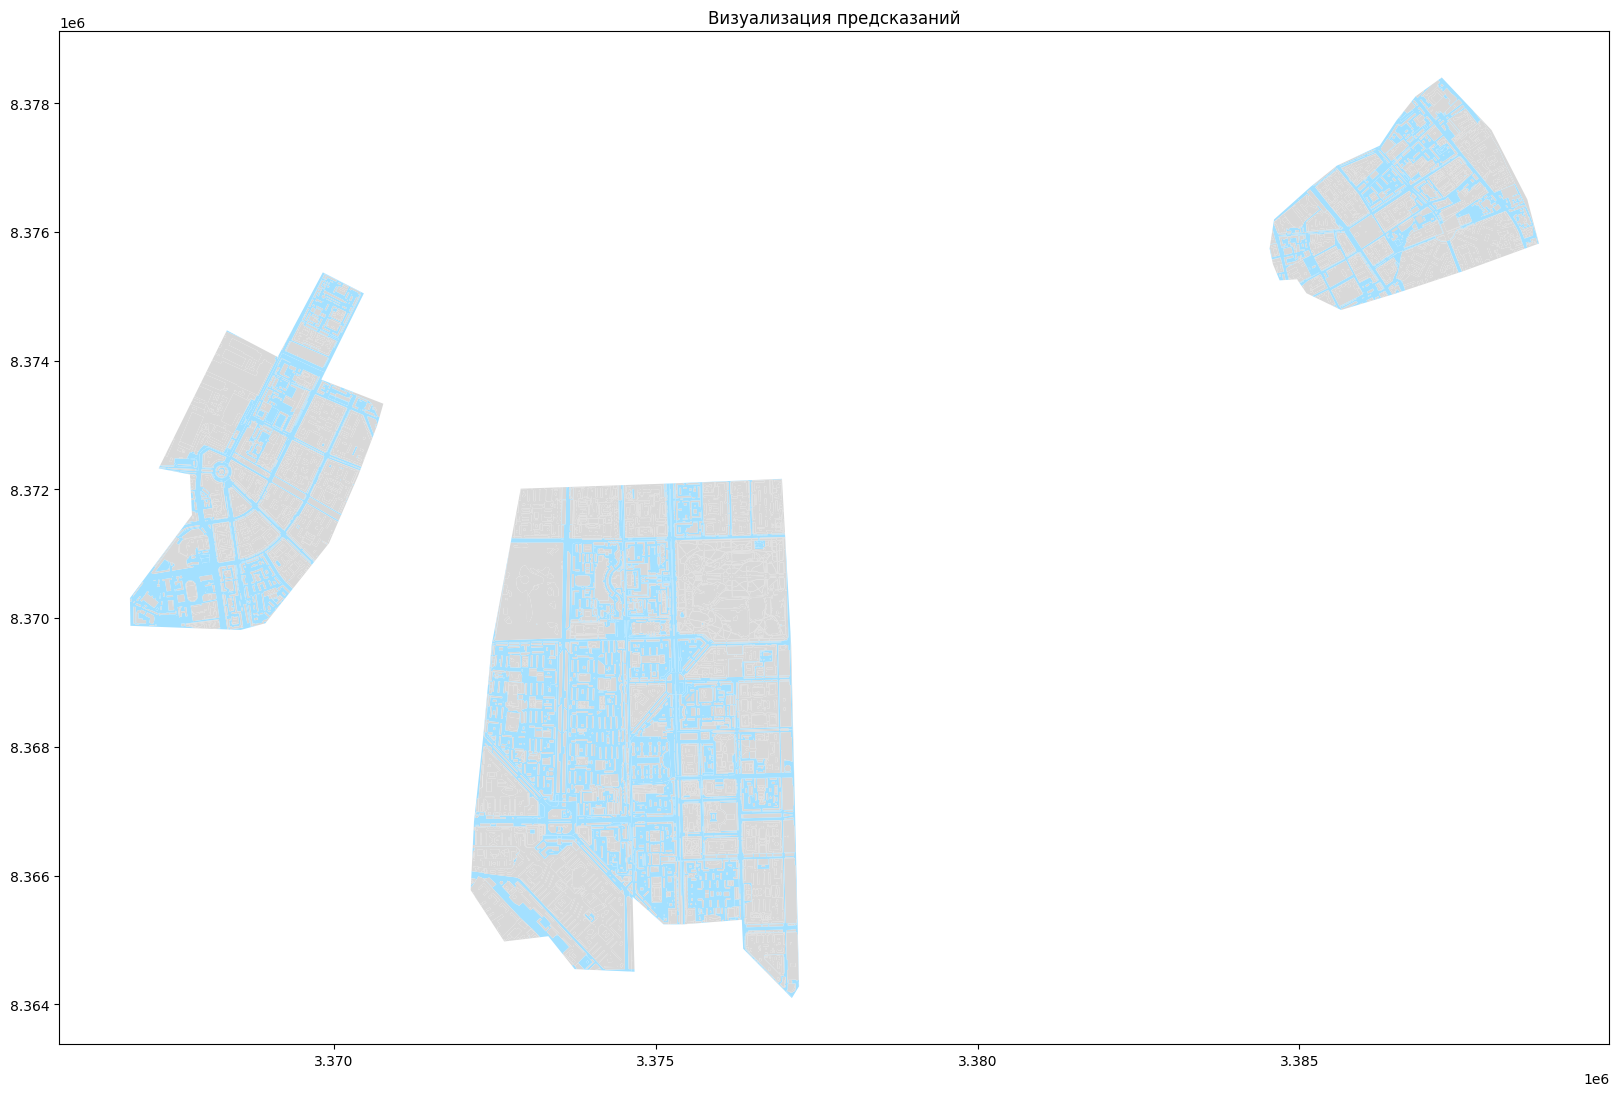

Геодатафрейм с предсказаниями сохранен в файл: predikt_0.84.gpkg


In [29]:
# Предсказание значения для всего набора данных

X_full = df_numeric.drop(columns=['non-place1']).fillna(0.0)  # Убедитесь, что NaN заменены
# Получаем имена признаков, на которых обучалась модель
trained_feature_names = X.columns.tolist()
# Проверяем, какие столбцы есть в полном GeoDataFrame
full_feature_names = df_numeric.drop(columns=['non-place1']).columns.tolist()
# Находим лишние столбцы в полном GeoDataFrame
extra_columns = set(full_feature_names) - set(trained_feature_names)

# Сохраняем геометрию отдельно
geometry = polygons.geometry
# Удаляем лишние столбцы, кроме geometry
gdfd_cleaned = df_numeric.drop(columns=extra_columns, errors='ignore')
# Создаем матрицу признаков для предсказания, без колонки non-place1 и geometry
X_full_cleaned = gdfd_cleaned.drop(columns=['non-place1'], errors='ignore').fillna(0.0)
# Получаем предсказания
predictions_full = pipeline.predict(X_full_cleaned)
# Создаем датафрейм с предсказаниями и добавляем геометрию
gdf_predictions = gpd.GeoDataFrame(gdfd_cleaned[['non-place1']].copy(), geometry=geometry)
gdf_predictions['Predicted_non_place1'] = predictions_full
# Визуализация
import matplotlib.pyplot as plt
color_map = {'non-place': '#a3e0ff', 'other': '#d8d8d8'}
gdf_predictions['color'] = gdf_predictions['Predicted_non_place1'].map(color_map)
gdf_predictions.plot(color=gdf_predictions['color'], figsize=(20, 20), alpha=1)
plt.title('Визуализация предсказаний')
plt.show()

# Сохранение геодатафрейма с предсказаниями в новый геофайл
accuracy = accuracy_score(y_test, y_pred)  # Получаем финальную точность
output_filename = f"predikt_{accuracy:.2f}.gpkg"  # Форматируем имя файла
gdf_predictions.to_file(output_filename, driver="GPKG")
print(f"Геодатафрейм с предсказаниями сохранен в файл: {output_filename}")

Удалено 0 признаков с нулевым влиянием
Осталось 133 значимых признаков


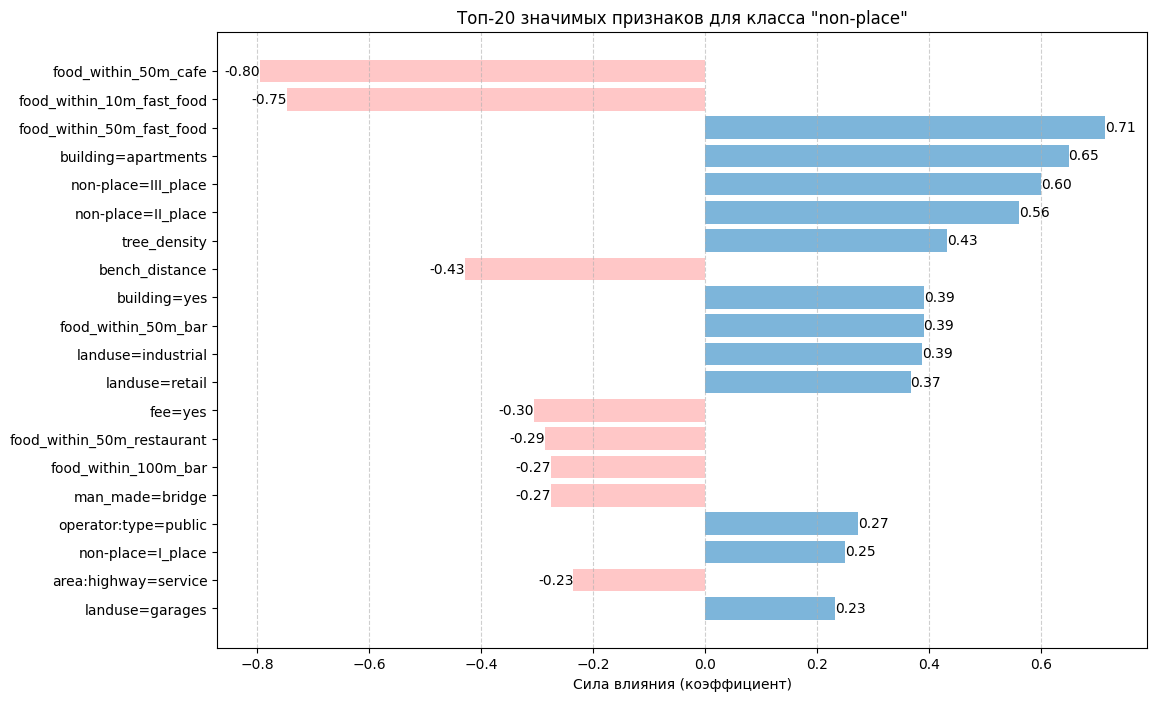

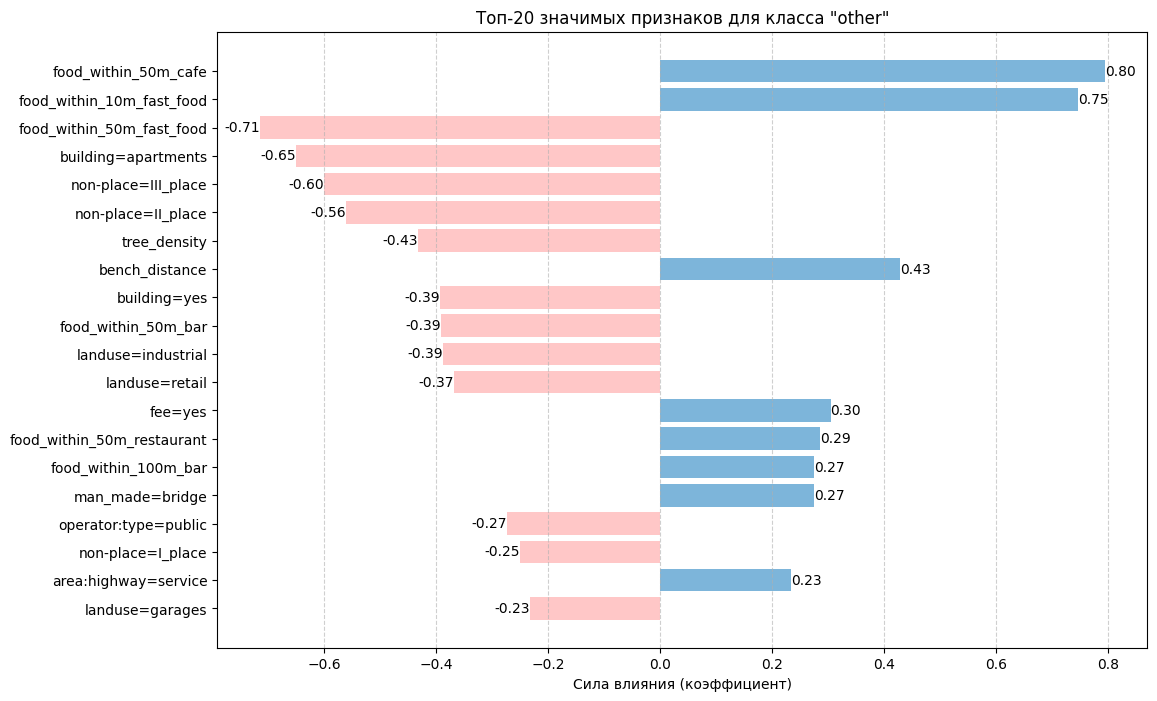


Сводная таблица влияния признаков (отсортировано по максимальному влиянию):


,non-place,other
food_within_50m_cafe,-0.80,0.80
food_within_10m_fast_food,-0.75,0.75
food_within_50m_fast_food,0.71,-0.71
building=apartments,0.65,-0.65
non-place=III_place,0.60,-0.60
non-place=II_place,0.56,-0.56
tree_density,0.43,-0.43
bench_distance,-0.43,0.43
building=yes,0.39,-0.39
food_within_50m_bar,0.39,-0.39


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Получаем модель из пайплайна
model = pipeline.named_steps['classifier']
feature_names = X.columns
classes = model.classes_

# Создаем DataFrame с коэффициентами
if len(classes) == 2:
    # Бинарная классификация - используем один набор коэффициентов
    coef_df = pd.DataFrame({
        'non-place': model.coef_[0],
        'other': -model.coef_[0]  # Инвертируем для бинарного случая
    }, index=feature_names)
else:
    # Мультиклассовая классификация - берем все коэффициенты
    coef_df = pd.DataFrame(
        data=model.coef_.T,
        columns=classes,
        index=feature_names
    )

# Удаляем признаки с нулевой значимостью для всех классов
nonzero_features = coef_df[(coef_df.abs() > 1e-6).any(axis=1)].index  # Учитываем погрешность вычислений
coef_df = coef_df.loc[nonzero_features]

print(f"Удалено {len(feature_names) - len(nonzero_features)} признаков с нулевым влиянием")
print(f"Осталось {len(nonzero_features)} значимых признаков")

# Обновляем визуализацию с учетом только значимых признаков
for class_name in ['non-place', 'other']:
    if class_name in coef_df.columns:
        top_df = coef_df[class_name].sort_values(key=abs, ascending=False).head(20)

        plt.figure(figsize=(12, 8))
        colors = ['#ffc7c7' if x < 0 else '#7db5da' for x in top_df]
        plt.barh(top_df.index, top_df, color=colors)

        # Добавляем аннотации с точными значениями
        for i, (feat, val) in enumerate(zip(top_df.index, top_df)):
            plt.text(val, i, f"{val:.2f}",
                    ha='left' if val > 0 else 'right',
                    va='center',
                    color='black')

        plt.title(f'Топ-20 значимых признаков для класса "{class_name}"')
        plt.xlabel('Сила влияния (коэффициент)')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.show()

# 2. ОБЪЕДИНЕННАЯ ТАБЛИЦА С СОРТИРОВКОЙ
print("\nСводная таблица влияния признаков (отсортировано по максимальному влиянию):")

# Сортируем по максимальному абсолютному влиянию (любого класса)
sorted_coef = coef_df.reindex(
    coef_df.abs().max(axis=1).sort_values(ascending=False).index
)

def mix_with_white(cmap_name, ratio=0.4):
    """Смешивает палитру с белым цветом"""
    cmap = plt.get_cmap(cmap_name)  # Получаем объект палитры по имени
    colors = cmap(np.linspace(0, 1, 256))
    white = np.array([1., 1., 1., 1.])
    mixed_colors = colors * (1 - ratio) + white * ratio
    return LinearSegmentedColormap.from_list(f'{cmap_name}_white', mixed_colors)

# Пример использования:
muted_piyg = mix_with_white('twilight')  # Теперь передаем имя палитры как строку

display(
    sorted_coef[['non-place', 'other']]
    .style
    .background_gradient(cmap=muted_piyg, axis=None, vmin=-2, vmax=2)
    .format("{:.2f}")
)

In [31]:
geo_df = gdf_predictions

In [32]:
print(pipeline.named_steps.keys())

dict_keys(['scaler', 'classifier'])


In [33]:
geo_df_filled = geo_df.fillna(0.0)

# Получаем имена признаков из ColumnTransformer
preprocessor = pipeline.named_steps['scaler']  # Получаем ColumnTransformer
# Получаем имена признаков после трансформации
feature_names = preprocessor.get_feature_names_out()

# Теперь извлекаем признаки (X) и целевую переменную (y)
X = geo_df_filled.reindex(columns=feature_names, fill_value=0)
y = geo_df_filled['non-place1']  # Целевая переменная

# Получаем вероятности для всего геодатафрейма с использованием классификатора
probabilities_full = pipeline.named_steps['classifier'].predict_proba(X)

# Записываем предсказанные вероятности в новый столбец в geo_df
geo_df['Predicted_Probability'] = probabilities_full[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [34]:
geo_df.columns

Index(['non-place1', 'geometry', 'Predicted_non_place1', 'color',
       'Predicted_Probability'],
      dtype='object')

In [35]:
geo_df = gpd.GeoDataFrame(
    geo_df[['non-place1', 'Predicted_Probability']],  # Выбранные столбцы
    geometry=geo_df.geometry  # Явное указание геометрии
)

In [36]:
# geo_df = gpd.read_file('path_to_geo_df.gpkg')
# geo_df = gpd.read_file('path_to_gdf_predictions.gpkg')
# Убедитесь, что оба GeoDataFrame имеют одинаковую систему координат
gdf_predictions = geo_df.to_crs(geo_df.crs)
# Объединение по геометрии, когда они точно равны
merged_gdf = geo_df.merge(gdf_predictions, left_on='geometry', right_on='geometry', how='inner')
# Если необходимо, удалите дублирующиеся столбцы, созданные при соединении
if 'geometry_right' in merged_gdf.columns:
    merged_gdf = merged_gdf.drop(columns=['geometry_right'])
# Если столбец index_right существует (добавлен при соединении), удалите его, если он не нужен
if 'index_right' in merged_gdf.columns:
    merged_gdf = merged_gdf.drop(columns=['index_right'])

In [37]:
merged_gdf

,non-place1_x,Predicted_Probability_x,geometry,non-place1_y,Predicted_Probability_y
0,other,0.88962,"MULTIPOLYGON (((3367404.785 8372587.3, 3367377...",other,0.88962
1,NaN,0.88962,"MULTIPOLYGON (((3368161.695 8372314.825, 33681...",NaN,0.88962
2,other,0.88962,"MULTIPOLYGON (((3369215.879 8372233.087, 33692...",other,0.88962
3,other,0.88962,"MULTIPOLYGON (((3369202.454 8371012.592, 33691...",other,0.88962
4,other,0.88962,"MULTIPOLYGON (((3369202.454 8371012.592, 33691...",other,0.88962
...,...,...,...,...,...
6856,other,0.88962,"MULTIPOLYGON (((3367974.331 8372207.807, 33679...",other,0.88962
6857,other,0.88962,"MULTIPOLYGON (((3368456.312 8372198.142, 33684...",other,0.88962
6858,other,0.88962,"MULTIPOLYGON (((3368626.932 8372076.923, 33685...",other,0.88962
6859,other,0.88962,"MULTIPOLYGON (((3368699.996 8372017.143, 33687...",other,0.88962


/tmp/ipython-input-40-1929416606.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', len(unique_non_place1))


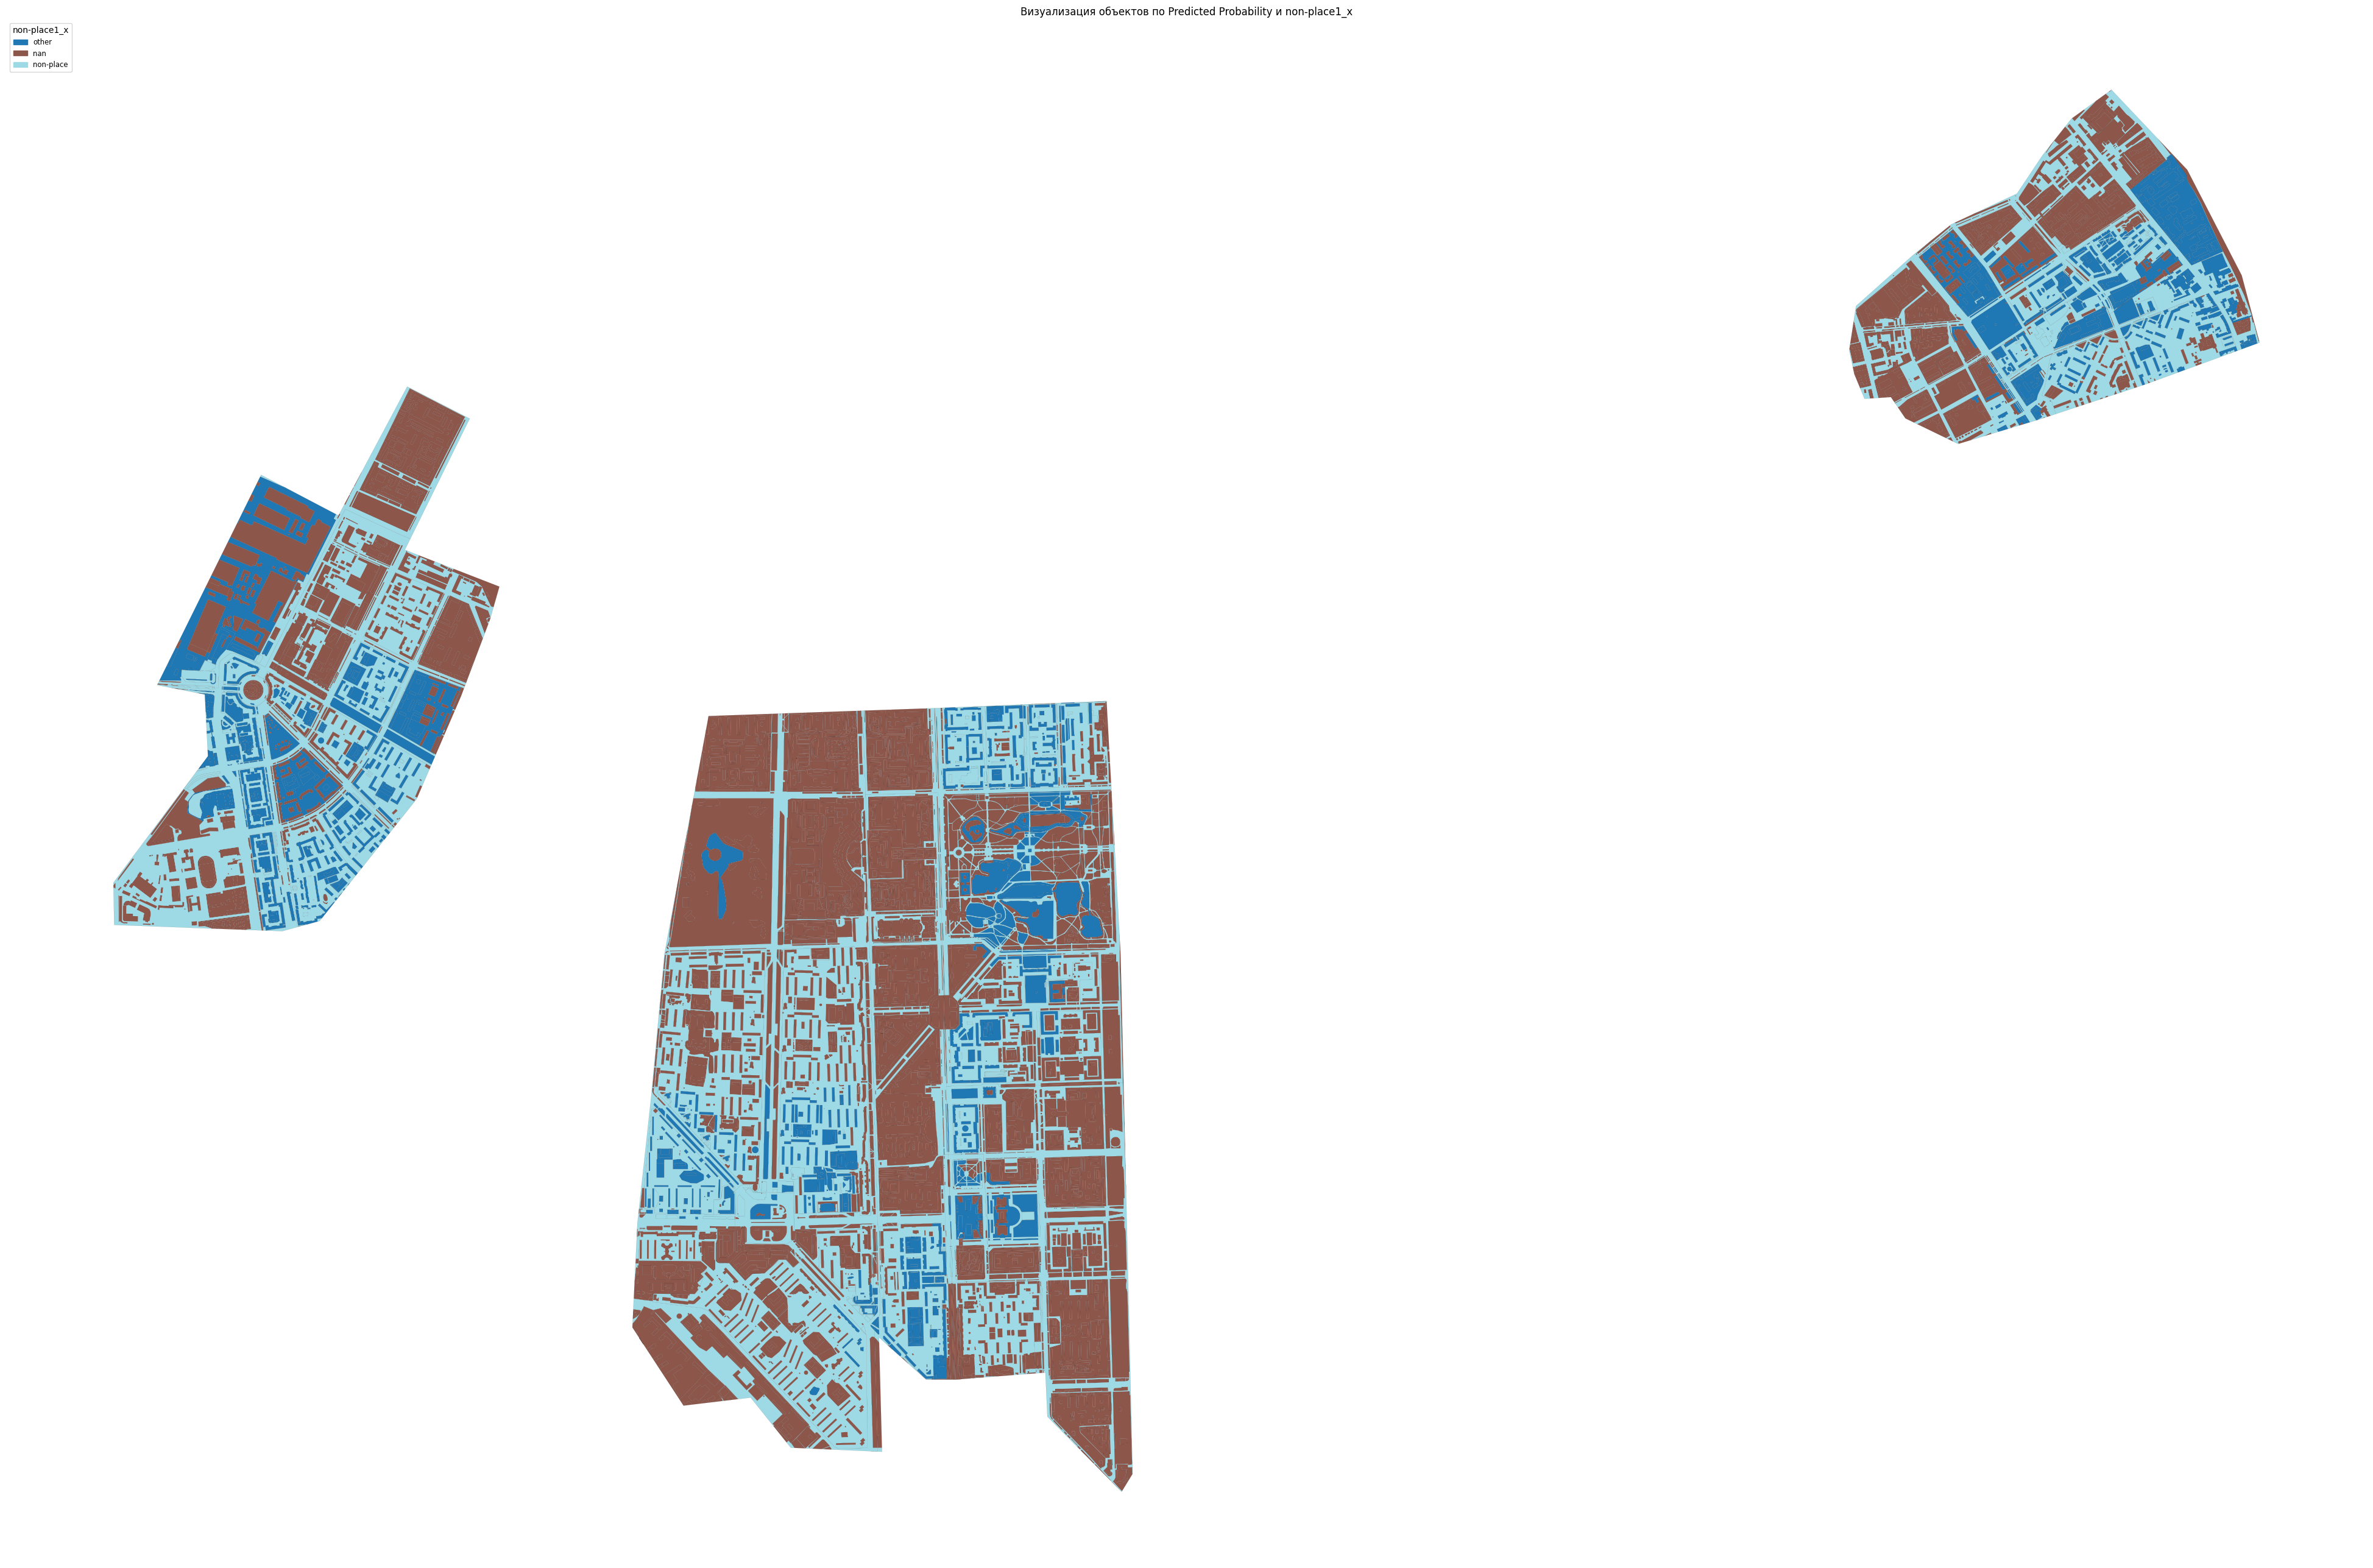

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
# 1. Создаем цветовую палитру
unique_non_place1 = merged_gdf['non-place1_x'].unique()
palette = plt.cm.get_cmap('tab20', len(unique_non_place1))
color_map = {value: mcolors.to_hex(palette(i))
             for i, value in enumerate(unique_non_place1)}
merged_gdf['color'] = merged_gdf['non-place1_x'].map(color_map)
# 2. Функция для уменьшения интенсивности цвета
def adjust_color(color, factor):
    rgb = mcolors.to_rgb(color)
    adjusted_rgb = [max(0, min(1, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted_rgb)
# 3. Применяем квантили к цветам
merged_gdf['quantile'] = pd.qcut(merged_gdf['Predicted_Probability_y'], q=num_quantiles, labels=False, duplicates='drop')
merged_gdf['adjusted_color'] = merged_gdf.apply(
    lambda row: adjust_color(row['color'], 1 - (row['quantile'] * 0.15)),
    axis=1
)

# 4. Создаем легенду
legend_handles = [mpatches.Patch(color=color_map[val], label=val)
                 for val in unique_non_place1]
# 5. Визуализация
fig, ax = plt.subplots(figsize=(50, 50))
merged_gdf.plot(ax=ax, color=merged_gdf['adjusted_color'],
               edgecolor='black', linewidth=0.05)
plt.legend(handles=legend_handles, title='non-place1_x',
          loc='upper left', fontsize='small', title_fontsize='medium')
plt.title('Визуализация объектов по Predicted Probability и non-place1_x')
plt.axis('off')
plt.show()

In [41]:
print(merged_gdf.columns)

Index(['non-place1_x', 'Predicted_Probability_x', 'geometry', 'non-place1_y',
       'Predicted_Probability_y', 'color', 'quantile', 'adjusted_color'],
      dtype='object')


In [42]:
geo_df.to_file("Predicte.gpkg", driver="GPKG")

# Эксперимент
Удаляем самые значимые параметры и проверяем, как изменится точность модели

In [43]:
# Основной цикл для обучения модели
iteration = 0
excluded_features = []  # Список для хранения исключенных признаков
# 1. Обучение и оценка модели на исходных данных
iteration += 1
# Разделение данных на признаки (X) и целевую переменную (y)
X = gdfd.drop(columns=['non-place1'])
y = gdfd['non-place1'].astype(str)
# Удаление строк с пропусками
X = X.fillna(0.0)
y = y[X.index]
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=5000, random_state=42))
])
# Обучение модели
pipeline.fit(X_train, y_train)
# Оценка модели
y_pred = pipeline.predict(X_test)
print(f"\n=== Итерация {iteration} ===")
print("Точность:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Получение коэффициентов
model = pipeline.named_steps['classifier']
feature_names = X.columns
coef_df = pd.DataFrame(model.coef_[0], index=feature_names, columns=['Coefficient'])
# 2. Удаление 10 самых значительных признаков
top_features_to_remove = coef_df.nlargest(10, 'Coefficient').index.tolist()
X_reduced = X.drop(columns=top_features_to_remove)
# Обучение и оценка модели на данных с удаленными признаками
iteration += 1
# Разделение на обучающую и тестовую выборки
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.15, random_state=40)
# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=5000, random_state=42))
])
# Обучение модели
pipeline.fit(X_train_reduced, y_train)
# Оценка модели
y_pred_reduced = pipeline.predict(X_test_reduced)
print(f"\n=== Итерация {iteration} ===")
print("Точность на данных с удаленными признаками:", accuracy_score(y_test, y_pred_reduced))
print(classification_report(y_test, y_pred_reduced))
# Сохранение коэффициентов
coef_df.to_csv("Коэффициенты.csv")


=== Итерация 1 ===
Точность: 0.8429752066115702
              precision    recall  f1-score   support

   non-place       0.70      0.17      0.27        42
       other       0.85      0.98      0.91       200

    accuracy                           0.84       242
   macro avg       0.77      0.58      0.59       242
weighted avg       0.82      0.84      0.80       242


=== Итерация 2 ===
Точность на данных с удаленными признаками: 0.8429752066115702
              precision    recall  f1-score   support

   non-place       0.70      0.17      0.27        42
       other       0.85      0.98      0.91       200

    accuracy                           0.84       242
   macro avg       0.77      0.58      0.59       242
weighted avg       0.82      0.84      0.80       242



In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
def mix_with_white(cmap_name, ratio=0.4):
    """Mixes a colormap with white to create a muted color palette."""
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, 256))
    white = np.array([1., 1., 1., 1.])
    mixed_colors = colors * (1 - ratio) + white * ratio
    return LinearSegmentedColormap.from_list(f'{cmap_name}_white', mixed_colors)
import numpy as np
import pandas as pd
from IPython.display import display
def mix_with_white(cmap_name, ratio=0.4):
    """
    Функция для смешивания цветовой карты с белым цветом.
    """
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.array([1, 1, 1, 1])  # RGBA для белого
    mixed_colors = (1 - ratio) * colors + ratio * white
    return mcolors.ListedColormap(mixed_colors)
def display_sorted_feature_influence(df, sort_column=None, cmap_name='twilight', ratio=0.4):
    """
    Отображает таблицу влияния объектов, отсортированную по абсолютному значению выбранного числового столбца,
    с оформлением фона градиентом.
    Параметры:
      - df: pd.DataFrame с названиями объектов в виде индексов и числовых столбцов влияния.
      - sort_column: str или None. Столбец для сортировки по абсолютному значению. Если None, используется первый числовой столбец.
      - cmap_name: str, цветовая карта matplotlib для базы градиента.
      - ratio: float, соотношение смешивания с белым, от 0 до 1.
    """
    # Проверка DataFrame
    if df.empty:
        print("DataFrame пуст.")
        return

    # Определяйте только числовые столбцы
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        print("В DataFrame не найдено числовых столбцов.")
        return

    # По умолчанию используйте указанный столбец сортировки или первый числовой столбец
    if sort_column is None:
        sort_column = numeric_cols[0]
    elif sort_column not in numeric_cols:
        print(f"Столбец '{sort_column}' не найден в числовых столбцах. Используем первый числовой столбец '{numeric_cols[0]}'.")
        sort_column = numeric_cols[0]

    # Удаление нулевых значений из выбранного столбца
    df = df[df[sort_column] != 0]

    # Сортировка DataFrame по убыванию значений целевого столбца
    sorted_index = df[sort_column].abs().sort_values(ascending=False).index
    sorted_df = df.loc[sorted_index]

    # Цвета
    muted_cmap = mix_with_white(cmap_name, ratio=ratio)

    # Определите vmin и vmax для градиента (симметричного вокруг нуля для лучшей визуализации)
    max_abs = np.nanmax(np.abs(sorted_df[sort_column]))
    vmin, vmax = -max_abs, max_abs

    # Отображение
    styled = (
        sorted_df.style
        .background_gradient(
            cmap=muted_cmap,
            subset=None,
            axis=None,
            vmin=vmin,
            vmax=vmax
        )
        .format("{:.3f}")
        .set_caption(f"Feature influence sorted by abs({sort_column})")
    )
    display(styled)

display_sorted_feature_influence(coef_df, sort_column='Coefficient1', cmap_name='twilight', ratio=0.4)

Столбец 'Coefficient1' не найден в числовых столбцах. Используем первый числовой столбец 'Coefficient'.


,Coefficient
food_within_50m_cafe,-0.797
food_within_10m_fast_food,-0.748
food_within_50m_fast_food,0.722
building=apartments,0.644
non-place=III_place,0.598
non-place=II_place,0.496
tree_density,0.432
bench_distance,-0.428
landuse=industrial,0.407
building=yes,0.393
